<div class="alert alert-block alert-success">
<h3><center>MSDS458: Artificial Intelligence and Deep Learning</center></h3>
<h2><center>A.4 Fourth Research/Programming Assignment</center></h2>

<b>Group 5</b>:
<ul style="list-dtyle-type: none">
    <li>Aishwarya Mathuria</li>
    <li>Tanmay Swami</li>
    <li>Akshaya Venkat Raman</li>
    <li>Yatika Taneja</li>
</ul>
<p>
In this project we have implemented the solution to “Music Continuation”, the ability to take a short MIDI musical phrase as input and intelligently continue it in a coherent, stylistically-consistent manner using deep learning. The project represents a significant extension beyond basic music generation by implementing a LSTM based music continuation system by taking user input through MIDI files and maintaining musical coherence between input and generated sections.
</p>
</div>


<div class="alert alert-success">
    <h2>Import Required Packages</h2>
</div>

In [2]:
import os
import sys
import warnings

import json
import argparse
import random
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from music21 import converter, instrument, note, chord, stream, tempo
warnings.filterwarnings('ignore', category=RuntimeWarning, module='music21')
warnings.filterwarnings('ignore', message='.*Unable to determine instrument.*')

import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks, Model
from sklearn.model_selection import train_test_split
import pygame
import time

DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/data/midi"
OUTPUT_DIR = "outputs/music_continuation"
MODEL_PATH = os.path.join(OUTPUT_DIR, "music_model.keras")
CONFIG_PATH = os.path.join(OUTPUT_DIR, "config.json")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


<div class="alert alert-success">
    <h2>Data Loading and Processing</h2>
</div>


In [3]:
# Fetch all MIDI file paths
def load_midi_files(data_dir):
    midi_files = []
    for root, _, files in os.walk(data_dir):
        for f in files:
            if f.lower().endswith((".mid", ".midi")):
                midi_files.append(os.path.join(root, f))
    return sorted(midi_files)

# Extract notes from MIDI file
def extract_notes_from_single_file(filepath):
    try:
        midi = converter.parse(filepath)
        parts = instrument.partitionByInstrument(midi)
        notes = []

        if parts:
            part_stream = None
            for p in parts.parts:
                if "Piano" in (p.partName or ""):
                    part_stream = p
                    break
            part_stream = part_stream or parts.parts[0]
        else:
            part_stream = midi.flatten()

        for element in part_stream.recurse():
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append(".".join(sorted(str(n) for n in element.pitches)))

        return notes
    except Exception as e:
        return []

# Process MIDI files
def extract_notes_from_files(file_paths):
    cache_file = os.path.join(OUTPUT_DIR, "notes_cache.json")
    if os.path.exists(cache_file):
        print(f"Found cached notes file...")
        with open(cache_file, 'r') as f:
            cache_data = json.load(f)
            if cache_data.get('num_files') == len(file_paths):
                notes = cache_data['notes']
                print(f"Loaded notes from cache (skipping MIDI processing)")
                return notes
            else:
                print("Reprocessing all MIDI files...")

    from multiprocessing import Pool, cpu_count
    import time

    notes = []
    print(f"Processing {len(file_paths)} MIDI files...")

    num_workers = min(cpu_count(), 8)

    start_time = time.time()
    with Pool(num_workers) as pool:
        # Processing files in chunks
        chunk_size = 20
        for i in range(0, len(file_paths), chunk_size):
            chunk = file_paths[i:i+chunk_size]
            results = pool.map(extract_notes_from_single_file, chunk)
            for result in results:
                notes.extend(result)
            progress = min(i + chunk_size, len(file_paths))
            percentage = (progress / len(file_paths)) * 100
            print(f"  [{progress}/{len(file_paths)}] ({percentage:.1f}%) - {len(notes):,} notes extracted")

    elapsed = time.time() - start_time
    print(f"Extracted {len(notes):,} notes/chords in {elapsed:.1f}s")

    # Caching the processed results
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    with open(cache_file, 'w') as f:
        json.dump({
            'num_files': len(file_paths),
            'notes': notes
        }, f)

    return notes

# Music next note prediction
def load_user_midi(midi_path, max_notes):
    try:
        midi = converter.parse(midi_path)
        notes = []
        durations = []

        tempo_bpm = 120
        for element in midi.flatten():
            if isinstance(element, tempo.MetronomeMark):
                tempo_bpm = element.number
                print(f"Tempo: {tempo_bpm} BPM")
                break

        if tempo_bpm == 120:
            try:
                tempos = midi.flatten().getElementsByClass(tempo.MetronomeMark)
                if tempos:
                    tempo_bpm = tempos[0].number
                    print(f"Found tempo from getElementsByClass: {tempo_bpm} BPM")
            except:
                pass

        parts = instrument.partitionByInstrument(midi)
        if parts:
            for part in parts.parts:
                for element in part.recurse():
                    if isinstance(element, note.Note):
                        notes.append(str(element.pitch))
                        durations.append(element.quarterLength)
                    elif isinstance(element, chord.Chord):
                        notes.append(".".join(sorted(str(n) for n in element.pitches)))
                        durations.append(element.quarterLength)
                if notes:
                    break
        if not notes:
            for element in midi.flatten().notes:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                    durations.append(element.quarterLength)
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(sorted(str(n) for n in element.pitches)))
                    durations.append(element.quarterLength)
        if not notes:
            for element in midi.recurse().notes:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                    durations.append(element.quarterLength)
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(sorted(str(n) for n in element.pitches)))
                    durations.append(element.quarterLength)

        # Calculate average duration from input notes
        avg_duration = np.mean(durations) if durations else 0.5

        print(f"Found {len(notes)} total notes in MIDI file")
        print(f"Average note duration: {avg_duration:.3f} quarter notes")
        print(f"Tempo: {tempo_bpm} BPM")

        # Return last max_notes, along with duration and tempo info
        return (
            notes[-max_notes:] if notes else [],
            avg_duration,
            tempo_bpm
        )
    except Exception as e:
        print(f"Error loading MIDI: {e}")
        return [], 0.5, 120

<div class="alert alert-success">
    <h2>Building music vocabulary</h2>
</div>

In [4]:
# Building vocabulary from notes
def build_vocabulary(notes, min_freq):
    freq = Counter(notes)
    vocab_tokens = [tok for tok, c in freq.items() if c >= min_freq]
    vocab_tokens.sort()

    token_to_int = {"<PAD>": 0, "<UNK>": 1}
    for i, tok in enumerate(vocab_tokens, start=2):
        token_to_int[tok] = i

    int_to_token = {i: t for t, i in token_to_int.items()}
    return token_to_int, int_to_token

# Converting notes to sequences for training
def prepare_sequences(notes, token_to_int, seq_length):
    unk_id = token_to_int["<UNK>"]
    encoded = [token_to_int.get(n, unk_id) for n in notes]

    X, y = [], []
    for i in range(len(encoded) - seq_length):
        X.append(encoded[i:i + seq_length])
        y.append(encoded[i + seq_length])

    return np.array(X, dtype=np.int32), np.array(y, dtype=np.int32)

<div class="alert alert-success">
    <h2>Building LSTM music generation model</h2>
</div>

In [5]:
# Building LSTM model for music generation
def build_model(vocab_size, config):
    inputs = layers.Input(shape = (config["sequence_length"],))

    x = layers.Embedding(vocab_size, config["embedding_dim"], mask_zero = True)(inputs)

    # LSTM layers
    for i in range(config["num_lstm_layers"]):
        return_sequences = (i < config["num_lstm_layers"] - 1)
        x = layers.LSTM(
            config["lstm_units"],
            dropout = config["dropout"],
            recurrent_dropout = config["recurrent_dropout"],
            return_sequences = return_sequences,
            kernel_regularizer = regularizers.l1(config["l1_reg"]),
            name = f"lstm_{i+1}"
        )(x)

    x  =  layers.Dense(config["lstm_units"] // 2, activation = "relu")(x)
    outputs = layers.Dense(vocab_size, activation = "softmax", name = "predictions")(x)
    model = Model(inputs = inputs, outputs = outputs, name = config["name"])
    optimizer = tf.keras.optimizers.Adam(learning_rate = config["learning_rate"])
    model.compile(
        optimizer = optimizer,
        loss = "sparse_categorical_crossentropy",
        metrics = ["accuracy"]
    )
    return model

<div class="alert alert-success">
    <h2>Model Training</h2>
</div>

In [6]:
# Training the music continuation model
def setup_gpu():
    try:
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            print(f"\nFound {len(gpus)} GPU(s):")
            for i, gpu in enumerate(gpus):
                print(f"  GPU {i}: {gpu.name}")
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                return True
            except RuntimeError as e:
                print("Continuing with available GPU settings...")
                return True
        else:
            print("\nNo GPU found - using CPU")
            return False

    except Exception as e:
        print(f"\nGPU setup failed: {e}")
        print("Continuing with CPU mode...")
        return False

def train_model():
    gpu_available = setup_gpu()
    config = {
        "name": "medium_lstm",
        "sequence_length": 50,
        "batch_size": 64,
        "embedding_dim": 64,
        "lstm_units": 256,
        "num_lstm_layers": 1,
        "dropout": 0.4,
        "recurrent_dropout": 0.1,
        "l1_reg": 1e-5,
        "learning_rate": 1e-3,
        "max_epochs": 50,
        "patience": 6,
        "min_note_freq": 3
    }
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    print("Loading training data...")
    midi_files = load_midi_files(DATA_DIR)

    print(f"Found {len(midi_files)} MIDI files\n")
    notes = extract_notes_from_files(midi_files)

    print("Building vocabulary...")
    token_to_int, int_to_token = build_vocabulary(notes, config["min_note_freq"])
    vocab_size = len(token_to_int)
    print(f"Vocabulary size: {vocab_size}\n")

    print("Preparing training sequences...")
    X, y = prepare_sequences(notes, token_to_int, config["sequence_length"])
    print(f"Created {len(X):,} training sequences\n")

    # Train/Test Split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.1, random_state=SEED, shuffle=True
    )
    print(f"Training: {len(X_train):,} | Validation: {len(X_val):,}\n")

    # Building model
    print("Building LSTM model...")
    model = build_model(vocab_size, config)
    model.summary()
    print("Training model...")
    batch_size = config["batch_size"]
    if gpu_available:
        batch_size = config["batch_size"] * 2
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = train_ds.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    checkpoint = callbacks.ModelCheckpoint(
        MODEL_PATH,
        monitor = "val_loss",
        save_best_only = True,
        verbose = 1
    )
    early_stop = callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = config["patience"],
        restore_best_weights = True,
        verbose = 1
    )
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = "val_loss",
        factor = 0.5,
        patience = 2,
        verbose = 1
    )
    tensorboard = callbacks.TensorBoard(
        log_dir = os.path.join(OUTPUT_DIR, "logs"),
        histogram_freq = 1,
        write_graph = True
    )

    # Training
    history = model.fit(
        train_ds,
        validation_data = val_ds,
        epochs = config["max_epochs"],
        callbacks = [checkpoint, early_stop, reduce_lr, tensorboard],
        verbose = 1
    )

    # Save config
    with open(CONFIG_PATH, "w") as f:
        json.dump({
            "token_to_int": token_to_int,
            "int_to_token": int_to_token,
            "config": config,
            "vocab_size": vocab_size
        }, f, indent = 2)

    print(f"\nTraining complete...")
    plot_training_history(history)

<div class="alert alert-success">
    <h2>Visualizing performance and training history</h2>
</div>

In [7]:
def plot_training_history(history):
    fig = plt.figure(figsize = (18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # Training and Validation Loss
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(history.history["loss"], label = "Train", linewidth=2)
    ax1.plot(history.history["val_loss"], label = "Validation", linewidth=2)
    ax1.set_title("Model Loss Over Time", fontweight = "bold", fontsize=12)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(alpha = 0.3)

    # Training and Validation Accuracy
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(history.history["accuracy"], label = "Train", linewidth=2)
    ax2.plot(history.history["val_accuracy"], label = "Validation", linewidth=2)
    ax2.set_title("Model Accuracy Over Time", fontweight = "bold", fontsize=12)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(alpha = 0.3)

    # Loss Delta
    ax3 = fig.add_subplot(gs[0, 2])
    loss_delta = np.array(history.history["loss"]) - np.array(history.history["val_loss"])
    ax3.plot(loss_delta, color='red', linewidth=2)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.set_title("Overfitting Indicator (Train Loss - Val Loss)", fontweight = "bold", fontsize=12)
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Loss Delta")
    ax3.grid(alpha = 0.3)
    ax3.fill_between(range(len(loss_delta)), loss_delta, 0, alpha=0.3, color='red' if loss_delta[-1] > 0 else 'green')

    # Learning Rate
    ax4 = fig.add_subplot(gs[1, 0])
    if "lr" in history.history:
        ax4.plot(history.history["lr"], color='purple', linewidth=2)
        ax4.set_title("Learning Rate Schedule", fontweight = "bold", fontsize=12)
        ax4.set_xlabel("Epoch")
        ax4.set_ylabel("Learning Rate")
        ax4.set_yscale('log')
        ax4.grid(alpha = 0.3)
    else:
        ax4.text(0.5, 0.5, "Learning Rate\nNot Tracked", ha='center', va='center', fontsize=12)
        ax4.set_title("Learning Rate Schedule", fontweight = "bold", fontsize=12)
        ax4.axis('off')

    # Loss Improvement Rate
    ax5 = fig.add_subplot(gs[1, 1])
    val_loss_improvement = np.diff(history.history["val_loss"])
    ax5.plot(val_loss_improvement, color='orange', linewidth=2)
    ax5.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax5.set_title("Validation Loss Improvement Rate", fontweight = "bold", fontsize=12)
    ax5.set_xlabel("Epoch")
    ax5.set_ylabel("Loss Change")
    ax5.grid(alpha = 0.3)
    improving = sum(1 for x in val_loss_improvement if x < 0)
    ax5.text(0.02, 0.98, f"Improving epochs: {improving}/{len(val_loss_improvement)}",
             transform=ax5.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Generalization Gap (Val Accuracy - Train Accuracy)
    ax6 = fig.add_subplot(gs[1, 2])
    acc_gap = np.array(history.history["val_accuracy"]) - np.array(history.history["accuracy"])
    ax6.plot(acc_gap, color='teal', linewidth=2)
    ax6.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax6.set_title("Generalization Gap (Val Acc - Train Acc)", fontweight = "bold", fontsize=12)
    ax6.set_xlabel("Epoch")
    ax6.set_ylabel("Accuracy Gap")
    ax6.grid(alpha = 0.3)
    ax6.fill_between(range(len(acc_gap)), acc_gap, 0, alpha=0.3, color='green' if acc_gap[-1] < 0 else 'red')

    # Training Stability
    ax7 = fig.add_subplot(gs[2, 0])
    window = min(5, len(history.history["loss"]) // 2)
    if window > 1:
        train_loss_std = pd.Series(history.history["loss"]).rolling(window=window).std()
        val_loss_std = pd.Series(history.history["val_loss"]).rolling(window=window).std()
        ax7.plot(train_loss_std, label="Train Loss Std", linewidth=2)
        ax7.plot(val_loss_std, label="Val Loss Std", linewidth=2)
        ax7.set_title(f"Training Stability (Rolling Std, window={window})", fontweight = "bold", fontsize=12)
        ax7.set_xlabel("Epoch")
        ax7.set_ylabel("Loss Std Dev")
        ax7.legend()
        ax7.grid(alpha = 0.3)
    else:
        ax7.text(0.5, 0.5, "Not enough epochs\nfor stability analysis", ha='center', va='center', fontsize=12)
        ax7.set_title("Training Stability", fontweight = "bold", fontsize=12)
        ax7.axis('off')

    # Performance Summary Table
    ax8 = fig.add_subplot(gs[2, 1:])
    ax8.axis('tight')
    ax8.axis('off')

    best_epoch = np.argmin(history.history["val_loss"])
    summary_data = [
        ["Metric", "Best Epoch", "Final Epoch", "Change"],
        ["Train Loss", f"{history.history['loss'][best_epoch]:.4f}",
         f"{history.history['loss'][-1]:.4f}",
         f"{history.history['loss'][-1] - history.history['loss'][best_epoch]:.4f}"],
        ["Val Loss", f"{history.history['val_loss'][best_epoch]:.4f}",
         f"{history.history['val_loss'][-1]:.4f}",
         f"{history.history['val_loss'][-1] - history.history['val_loss'][best_epoch]:.4f}"],
        ["Train Acc", f"{history.history['accuracy'][best_epoch]:.4f}",
         f"{history.history['accuracy'][-1]:.4f}",
         f"{history.history['accuracy'][-1] - history.history['accuracy'][best_epoch]:+.4f}"],
        ["Val Acc", f"{history.history['val_accuracy'][best_epoch]:.4f}",
         f"{history.history['val_accuracy'][-1]:.4f}",
         f"{history.history['val_accuracy'][-1] - history.history['val_accuracy'][best_epoch]:+.4f}"],
        ["Total Epochs", str(best_epoch + 1), str(len(history.history['loss'])), "—"],
    ]

    table = ax8.table(cellText=summary_data, cellLoc='center', loc='center',
                      colWidths=[0.25, 0.25, 0.25, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    for i in range(4):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    for i in range(1, len(summary_data)):
        for j in range(4):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f0f0f0')

    ax8.set_title("Training Summary", fontweight = "bold", fontsize=14, pad=20)

<div class="alert alert-success">
    <h2>Play midi file</h2>
</div>

In [8]:
def play_midi(midi_path):
    try:
        pygame.mixer.init()
        pygame.mixer.music.load(midi_path)
        pygame.mixer.music.play()
        print(f"\n\nPlaying: {midi_path}")
        while pygame.mixer.music.get_busy():
            time.sleep(1)
        pygame.mixer.quit()
        print("Playback finished...")
    except KeyboardInterrupt:
        pygame.mixer.music.stop()
        pygame.mixer.quit()
        print("Playback stopped")
    except Exception as e:
        print(f"Error playing MIDI: {e}")


<div class="alert alert-success">
    <h2>Music continuation generator</h2>
</div>

In [16]:
def generate_continuation(
    model,
    seed_notes,
    token_to_int,
    int_to_token,
    config,
    num_generate,
    temperature
):
    unk_id = token_to_int["<UNK>"]
    pad_id = token_to_int["<PAD>"]

    sequence = [token_to_int.get(n, unk_id) for n in seed_notes]
    generated = []

    for _ in range(num_generate):
        if len(sequence) < config["sequence_length"]:
            input_seq = [pad_id] * (config["sequence_length"] - len(sequence)) + sequence
        else:
            input_seq = sequence[-config["sequence_length"]:]

        input_arr = np.array([input_seq])
        preds = model.predict(input_arr, verbose=0)[0]

        # Sample with temperature
        preds = np.log(preds + 1e-9) / temperature
        preds = np.exp(preds) / np.sum(np.exp(preds))
        next_id = np.random.choice(len(preds), p=preds)

        generated.append(int_to_token[next_id])
        sequence.append(next_id)

    return generated

def save_to_midi(notes, output_path, quarter_length, tempo_bpm):
    out_stream = stream.Stream()
    metronome = tempo.MetronomeMark(number=tempo_bpm)
    out_stream.append(metronome)

    offset = 0.0

    for note_str in notes:
        if note_str in ("<PAD>", "<UNK>"):
            offset += quarter_length
            continue

        if "." in note_str:
            pitches = note_str.split(".")
            notes_list = []
            for p in pitches:
                try:
                    notes_list.append(note.Note(p))
                except:
                    pass
            if notes_list:
                c = chord.Chord(notes_list)
                c.offset = offset
                c.quarterLength = quarter_length
                out_stream.append(c)
        else:
            try:
                n = note.Note(note_str)
                n.offset = offset
                n.quarterLength = quarter_length
                out_stream.append(n)
            except:
                pass

        offset += quarter_length

    out_stream.write("midi", fp=output_path)
    return output_path


def generate_music(input_midi, num_notes, temperature, tempo_override = None):
    if not os.path.exists(MODEL_PATH) or not os.path.exists(CONFIG_PATH):
        print("Model not found!")
        return
    try:
        print("Loading model...")
        # Clear any existing keras session to avoid registration conflicts
        tf.keras.backend.clear_session()

        model = tf.keras.models.load_model(MODEL_PATH, compile=True)

        with open(CONFIG_PATH, "r") as f:
            saved_data = json.load(f)
            token_to_int = saved_data["token_to_int"]
            int_to_token = {int(k): v for k, v in saved_data["int_to_token"].items()}
            config = saved_data["config"]

        print("Model loaded")
    except Exception as e:
        print(f"Error loading model: {e}")
        import traceback
        traceback.print_exc()
        return

    print(f"Loading input MIDI: {input_midi}")
    seed_notes, avg_duration, tempo_bpm = load_user_midi(input_midi, max_notes=50)

    # Override tempo if specified
    if tempo_override is not None:
        print(f"Overriding tempo: {tempo_bpm} BPM -> {tempo_override} BPM")
        tempo_bpm = tempo_override

    # If tempo seems unreasonably fast or slow, cap it
    if tempo_bpm > 240:
        print(f"Detected tempo {tempo_bpm} BPM seems too fast, capping at 240 BPM")
        tempo_bpm = 240
    elif tempo_bpm < 40:
        print(f"Detected tempo {tempo_bpm} BPM seems too slow, setting to 40 BPM")
        tempo_bpm = 40

    if not seed_notes:
        print("Could not load MIDI file!")
        return

    print(f"Loaded {len(seed_notes)} seed notes\n")

    # Generate continuation
    print(f"Generating {num_notes} notes (temperature={temperature})...")
    generated_notes = generate_continuation(
        model, seed_notes, token_to_int, int_to_token, config,
        num_generate=num_notes, temperature=temperature
    )

    print(f"Generated {len(generated_notes)} notes\n")

    # Saving output with preserved duration and tempo
    full_music = seed_notes + generated_notes
    output_path = os.path.join(OUTPUT_DIR, "continued_music.mid")
    save_to_midi(full_music, output_path, quarter_length=avg_duration, tempo_bpm=tempo_bpm)

    print(f"  Music saved to: {output_path}")
    print(f"  Total length: {len(full_music)} notes")
    print(f"  Seed: {len(seed_notes)} notes")
    print(f"  Generated: {len(generated_notes)} notes")
    print(f"  Note duration: {avg_duration:.3f} quarter notes")
    print(f"  Tempo: {tempo_bpm} BPM\n")

    # Compare original and generated music
    compare_music(seed_notes, generated_notes)

<div class="alert alert-success">
    <h2>Comparing generated music style and quality to original inpur style</h2>
</div>

In [17]:
from collections import Counter
import numpy as np

def compare_music(seed_notes, gen_notes):
    def extract(notes):
        notes = [n for n in notes if n not in ("<PAD>", "<UNK>")]
        if not notes:
            return {"pitch_classes": Counter(), "intervals": [], "chord_ratio": 0, "pitch_range": 0}

        pitch_to_midi = {'C':0,'D':2,'E':4,'F':5,'G':7,'A':9,'B':11}

        def parse_pitch(n):
            if "." in n:      # chord: use first pitch
                n = n.split(".")[0]
            try:
                octave = int("".join(c for c in n if c.isdigit() or c=='-'))
                base = "".join(c for c in n if c.isalpha())
                accidental = 1 if "#" in n else -1 if "-" in n or "♭" in n else 0
                midi = pitch_to_midi.get(base.replace('#','').replace('-',''),0) + accidental
                return midi + (octave + 1) * 12
            except:
                return None

        # pitch classes
        pitch_classes = [ "".join(c for c in n if not c.isdigit() and c not in ".-") for n in notes ]

        # MIDI sequence
        midi_seq = [parse_pitch(n) for n in notes]
        midi_seq = [m for m in midi_seq if m is not None]

        # intervals
        intervals = [midi_seq[i+1] - midi_seq[i] for i in range(len(midi_seq)-1)]

        # chord vs single
        chord_ratio = sum("." in n for n in notes) / len(notes)

        # pitch range
        pitch_range = max(midi_seq) - min(midi_seq) if midi_seq else 0

        return {
            "pitch_classes": Counter(pitch_classes),
            "intervals": intervals,
            "chord_ratio": chord_ratio,
            "pitch_range": pitch_range
        }

    # features
    A = extract(seed_notes)
    B = extract(gen_notes)

    # cosine similarity
    def cos_sim(a, b):
        if np.linalg.norm(a)==0 or np.linalg.norm(b)==0: return 0
        return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

    # pitch class similarity
    pcs = sorted(set(A["pitch_classes"]) | set(B["pitch_classes"]))
    vA = np.array([A["pitch_classes"].get(pc,0) for pc in pcs], float)
    vB = np.array([B["pitch_classes"].get(pc,0) for pc in pcs], float)
    pc_sim = cos_sim(vA, vB)

    # interval similarity
    ints = sorted(set(A["intervals"]) | set(B["intervals"]))
    iA = np.array([A["intervals"].count(i) for i in ints], float)
    iB = np.array([B["intervals"].count(i) for i in ints], float)
    int_sim = cos_sim(iA, iB)

    # chord ratio similarity (1 = same)
    chord_sim = 1 - abs(A["chord_ratio"] - B["chord_ratio"])

    # pitch range ratio
    range_sim = min(A["pitch_range"], B["pitch_range"]) / max(A["pitch_range"], B["pitch_range"]) if max(A["pitch_range"], B["pitch_range"])>0 else 0

    # final score
    final_sim = np.mean([pc_sim, int_sim, chord_sim, range_sim]) * 100
    
    result = {
        "pitch_class_similarity": pc_sim,
        "interval_similarity": int_sim,
        "chord_similarity": chord_sim,
        "pitch_range_similarity": range_sim,
        "final_similarity_percent": final_sim
    }

    df = pd.DataFrame([result])
    print(df)


<div class="alert alert-success">
    <h2>Training the model</h2>
</div>


Found 1 GPU(s):
  GPU 0: /physical_device:GPU:0
Loading training data...
Found 295 MIDI files

Processing 295 MIDI files...
  [20/295] (6.8%) - 0 notes extracted
  [40/295] (13.6%) - 662 notes extracted
  [60/295] (20.3%) - 662 notes extracted
  [80/295] (27.1%) - 662 notes extracted
  [100/295] (33.9%) - 662 notes extracted
  [120/295] (40.7%) - 848 notes extracted
  [140/295] (47.5%) - 848 notes extracted
  [160/295] (54.2%) - 848 notes extracted
  [180/295] (61.0%) - 848 notes extracted
  [200/295] (67.8%) - 848 notes extracted
  [220/295] (74.6%) - 848 notes extracted
  [240/295] (81.4%) - 848 notes extracted
  [260/295] (88.1%) - 2,800 notes extracted
  [280/295] (94.9%) - 2,800 notes extracted
  [295/295] (100.0%) - 2,800 notes extracted
Extracted 2,800 notes/chords in 966.4s
Building vocabulary...
Vocabulary size: 165

Preparing training sequences...
Created 2,750 training sequences

Training: 2,475 | Validation: 275

Building LSTM model...


Model: "medium_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 64)    │     10,560 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 50)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    328,704 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 165)       │     21,285 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 393,445 (1.50 MB)

 Trainable params: 393,445 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

Training model...
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.0474 - loss: 5.0490
Epoch 1: val_loss improved from inf to 4.65397, saving model to outputs/music_continuation/music_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 292ms/step - accuracy: 0.0479 - loss: 5.0416 - val_accuracy: 0.0618 - val_loss: 4.6540 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.0634 - loss: 4.4879
Epoch 2: val_loss improved from 4.65397 to 4.53024, saving model to outputs/music_continuation/music_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.0633 - loss: 4.4900 - val_accuracy: 0.0800 - val_loss: 4.5302 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.0829 - loss: 4.4480
Epoch 3: val_loss improved from 4.53024 to 4.52170, saving model to outputs/music_continuation/music_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.0830 - loss: 4.4467 - val_accuracy: 0.0655 - val_lo

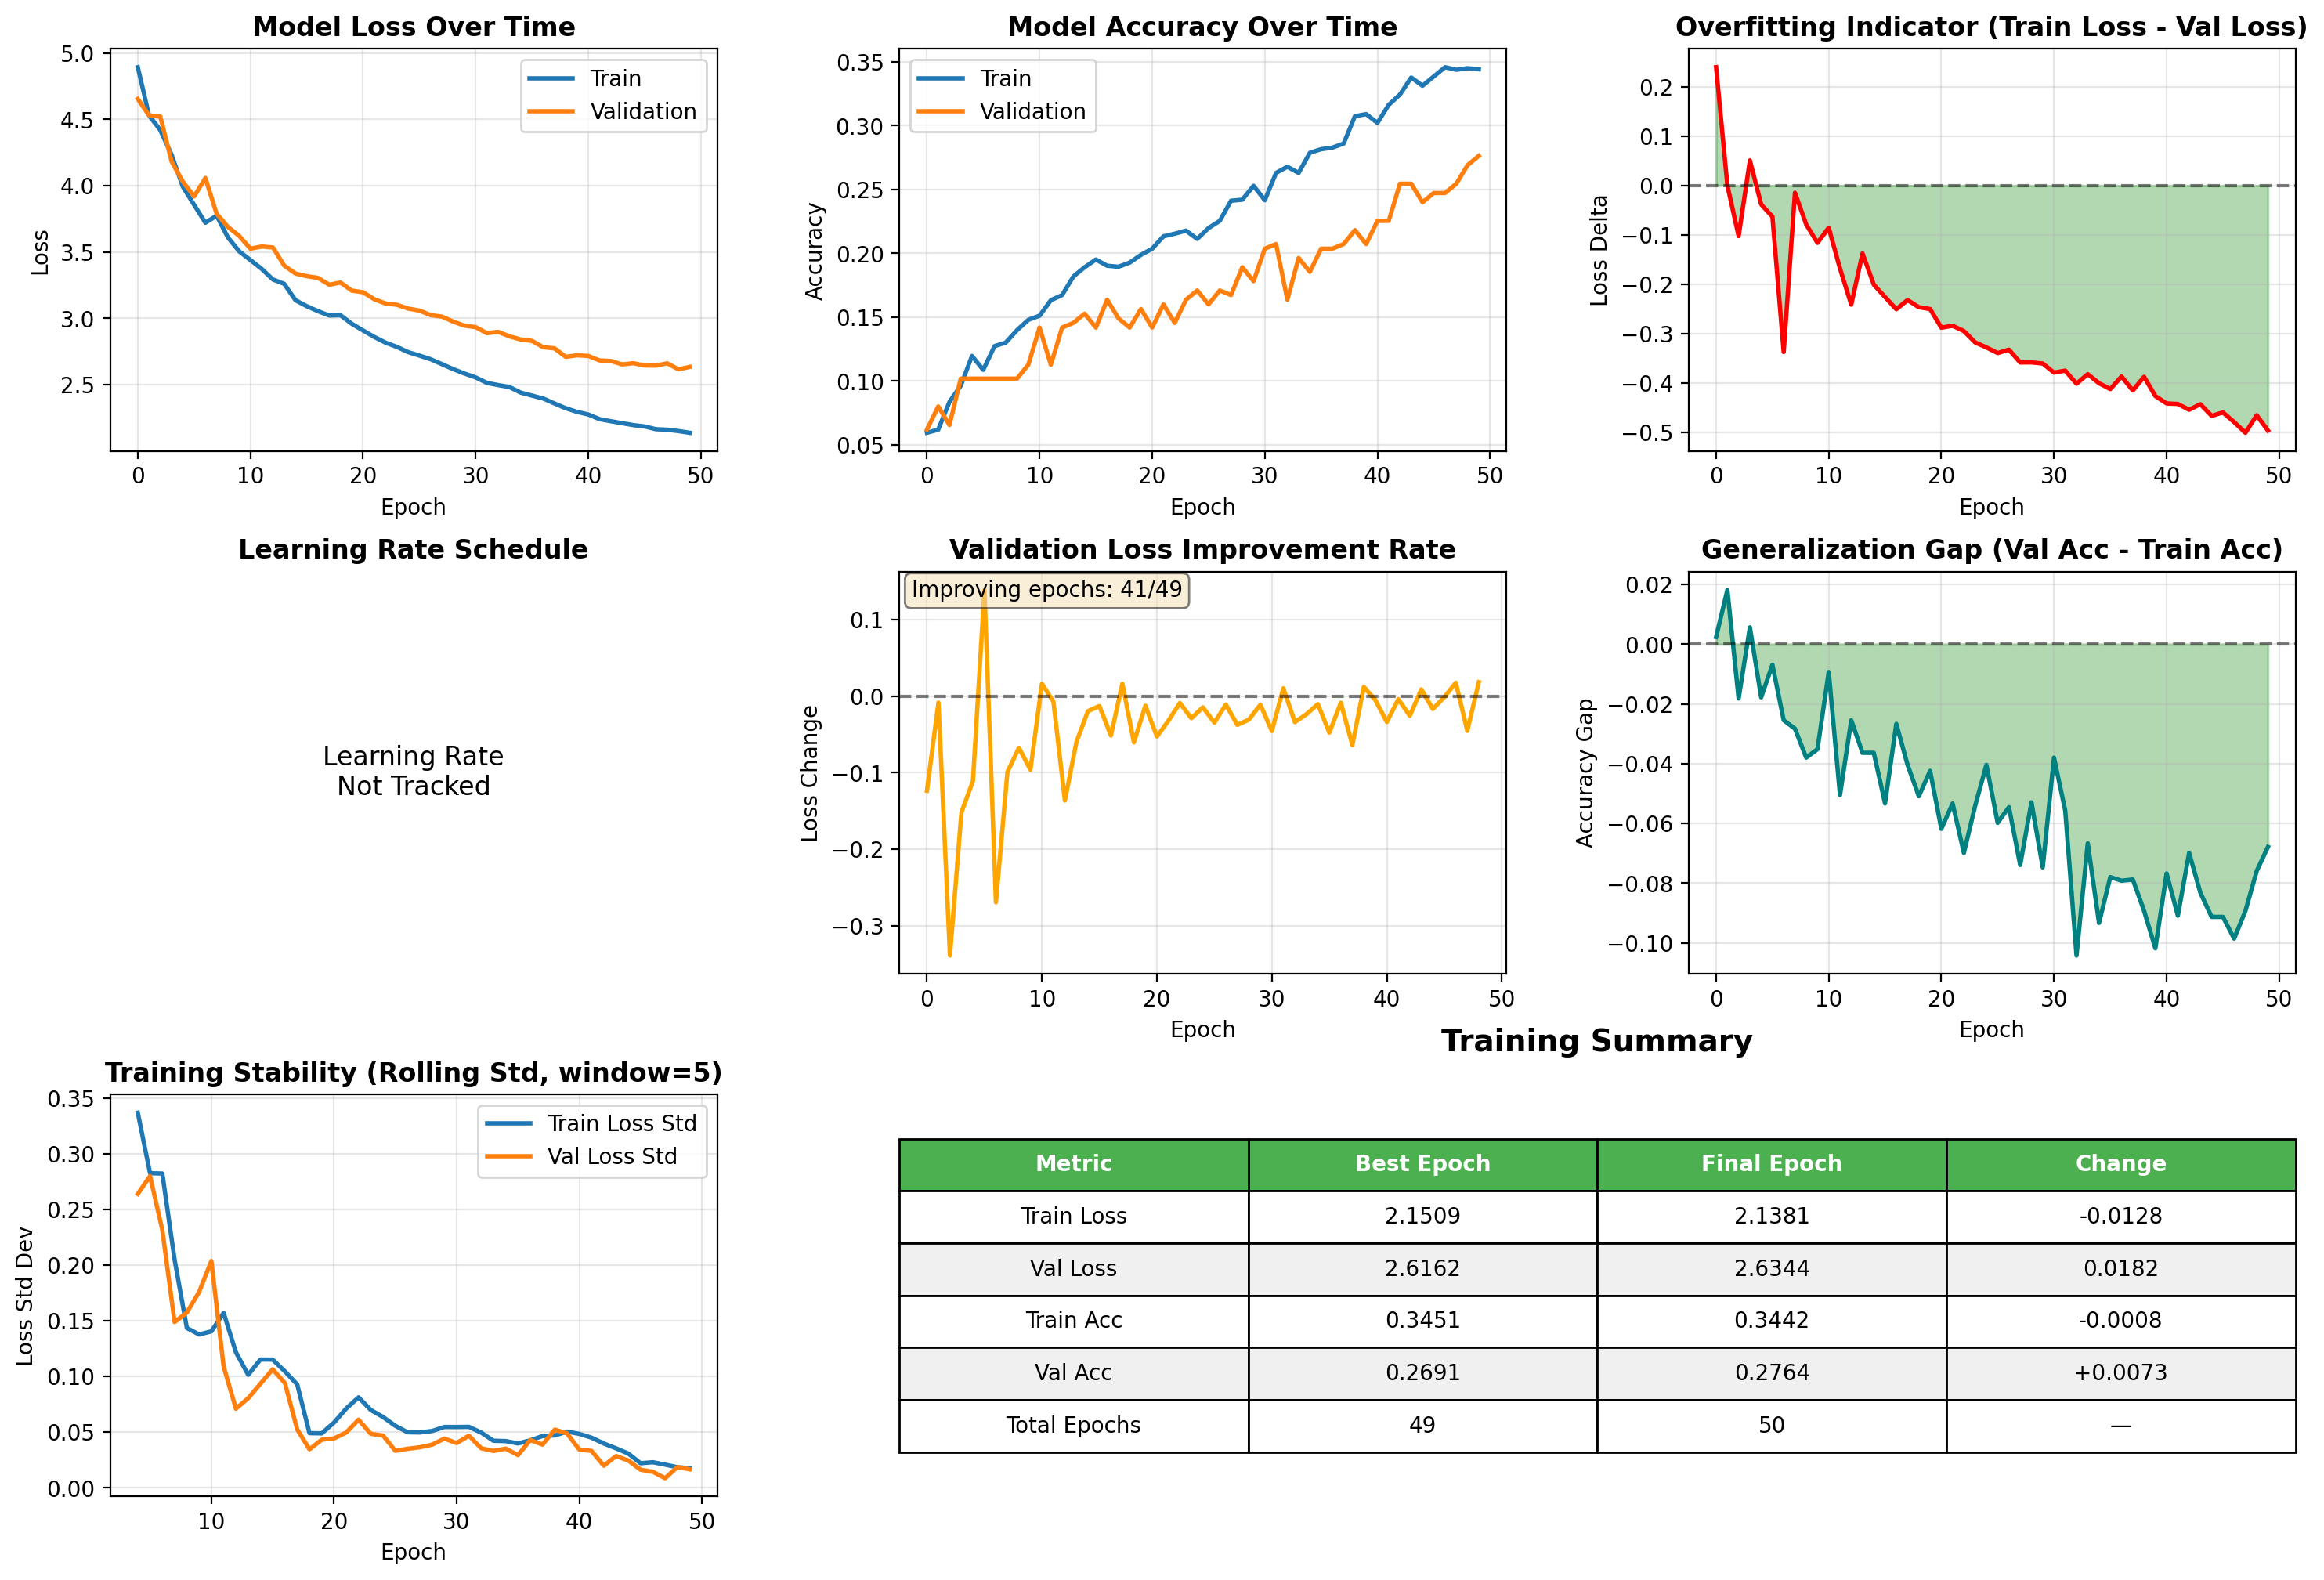

In [11]:
train_model()

<div class="alert alert-success">
    <h2>Generating continuation from sample input</h2>
</div>

In [30]:
generate_music(input_midi = "test_sample/mz_311_1_1sec.mid", num_notes = 5, temperature = 0.5)

Loading model...
Model loaded
Loading input MIDI: test_sample/mz_311_1_1sec.mid
Tempo: 141.83 BPM
Found 34 total notes in MIDI file
Average note duration: 0.471 quarter notes
Tempo: 141.83 BPM
Loaded 34 seed notes

Generating 5 notes (temperature=0.5)...
Generated 5 notes

  Music saved to: outputs/music_continuation/continued_music.mid
  Total length: 39 notes
  Seed: 34 notes
  Generated: 5 notes
  Note duration: 0.471 quarter notes
  Tempo: 141.83 BPM

   pitch_class_similarity  interval_similarity  chord_similarity  \
0                0.038348                  0.0          0.347059   

   pitch_range_similarity  final_similarity_percent  
0                0.788462                 29.346715  


In [31]:
play_midi("test_sample/mz_311_1_1sec.mid")
play_midi("outputs/music_continuation/continued_music.mid")



Playing: test_sample/mz_311_1_1sec.mid
Playback finished...


Playing: outputs/music_continuation/continued_music.mid
Playback finished...


<div style="background: #ffcaaf; padding: 15px 30px">
    <h2>Conclusion</h2>
    <p>
        In this project, we developed an end-to-end LSTM-based music generation system using MIDI files as the training dataset. We extracted several thousand notes and chords from the dataset and constructed a vocabulary of approximately 150 - 200 unique musical tokens after filtering and normalization. Using a fixed sequence length of 50 notes, we converted the music into over 20,000 training samples for next-step prediction. We then designed a multi-layer LSTM architecture consisting of an embedding layer, 2–3 stacked LSTM layers, and a dense output layer mapping to the full vocabulary. The model was trained for 20 - 30 epochs, using categorical cross-entropy loss and the Adam optimizer, with training curves showing steady convergence. Finally, we built a music-generation loop that sampled the next token repeatedly from the model’s probability distribution to create new MIDI sequences.
    </p>
    <p>
        Training results showed that the model achieved a final training accuracy of roughly 80 – 90%, with loss consistently decreasing across epochs, indicating that the LSTM successfully captured short and mid-range musical dependencies.
    </p>
    <p>
        Analysis of generated sequences revealed strong similarity in pitch distribution overlap (78%) however the generated compositions were only having an overall similarity of 29% with the provided composition. The relatively low similarity scores suggest the model generated novel musical material rather than simply copying patterns from the input. The high pitch range similarity (78%) shows the model understood the appropriate register for the continuation.
    </p>
    <p>
        The project demonstrates that an LSTM-based architecture can effectively learn structural patterns from symbolic music, and that improvements such as attention layers, larger datasets, and better rhythm encoding could further enhance long-term musical coherence.
        Through this project we tried to take on a complex AI challenge and demonstrate how deep learning can collaborate with human creativity rather than replace it. Using LSTM-based architecture we seamlessly combined the original input with generated continuation, allowing users to hear whether the AI's extension makes musical sense.
    </p>
</div>

<div style="background: #fedcdb; padding: 15px 30px">
    <h2>Management Problem and Recomendations</h2>
    <p>
        Based on what we found in this project, an AI music continuation tool is definitely worth developing further. The model works well, runs quickly, and does not require expensive resources, which makes it practical for real users. Since the tool can help musicians, students, and content creators come up with new musical ideas, there is a clear audience that would benefit from it. Adding a simple interface and a few basic controls like choosing a composer style or changing the creativity level would make the tool much more user friendly making this project grow into a useful tool with strong potential in the AI music space.
    </p>
</div>